### Импорты используемых библиотек:

In [34]:
%matplotlib inline
import math 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
sns.set(style="darkgrid")
import numpy as np
from ipywidgets import interact, IntSlider, fixed, FloatSlider
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### Загрузка датасета:

In [35]:
data_set = pd.read_csv('../data/economic_freedom.csv', encoding="ISO-8859-1")
data_set = data_set.drop(["Country", "WEBNAME"], axis=1)

### Переименуем столбцы в соответствии со snake_case:

In [36]:
data_set.columns = ['id', 'name', 'region', 'world_rank',
       'region_rank', 'score', 'property_rights', 'judical_effectiveness',
       'gov_integrity', 'tax_burden', 'gov_spending', 'fiscal_health',
       'business_freedom', 'labor_freedom', 'monetary_freedom',
       'trade_freedom', 'investment_freedom ', 'financial_freedom',
       'tariff_rate', 'income_tax_rate', 'corp_tax_rate',
       'tax_burden', 'gov_expenditure',
       'population', 'gdp', 'gdp_growth_rate',
       'five_year_gdp_growth_rate', 'gdp_per_capita',
       'unemployment', 'inflation', 'fdi_inflow',
       'public_debt']

### Заменим невалидные символы и удалим невалидные значения:

In [37]:
data_set.gdp = data_set.gdp.str[1:]
data_set.fdi_inflow = data_set.fdi_inflow.str[1:]
data_set.gdp_per_capita = data_set.gdp_per_capita.str[1:]
data_set.gdp = data_set.gdp.str.replace(',', '')
data_set.fdi_inflow = data_set.fdi_inflow.str.replace(',', '')
data_set.gdp_per_capita = data_set.gdp_per_capita.str.replace(',', '')

In [38]:
data_set

,id,name,region,world_rank,region_rank,score,property_rights,judical_effectiveness,gov_integrity,tax_burden,...,gov_expenditure,population,gdp,gdp_growth_rate,five_year_gdp_growth_rate,gdp_per_capita,unemployment,inflation,fdi_inflow,public_debt
0,1,Afghanistan,Asia-Pacific,152.0,39.0,51.5,19.6,29.6,25.2,91.7,...,25.6,35.5,69.6,2.5,2.9,1958,8.8,5.0,3.9,7.3
1,2,Albania,Europe,52.0,27.0,66.5,54.8,30.6,40.4,86.3,...,29.5,2.9,36.0,3.9,2.5,12507,13.9,2.0,119.1,71.2
2,3,Algeria,Middle East and North Africa,171.0,14.0,46.2,31.6,36.2,28.9,76.4,...,41.4,41.5,632.9,2.0,3.1,15237,10.0,5.6,203.0,25.8
3,4,Angola,Sub-Saharan Africa,156.0,33.0,50.6,35.9,26.6,20.5,83.9,...,25.3,28.2,190.3,0.7,2.9,6753,8.2,31.7,2254.5,65.3
4,5,Argentina,Americas,148.0,26.0,52.2,47.8,44.5,33.5,69.3,...,41.0,44.1,920.2,2.9,0.7,20876,8.7,25.7,1857.0,52.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,179,Venezuela,Americas,179.0,32.0,25.9,7.6,13.1,7.9,74.7,...,37.4,31.4,380.7,-14.0,-7.8,12114,7.7,1087.5,68.0,34.9
182,180,Vietnam,Asia-Pacific,128.0,30.0,55.3,49.8,40.3,34.0,79.7,...,29.4,93.6,647.4,6.8,6.2,6913,2.1,3.5,4100.0,58.2
183,181,Yemen,Middle East and North Africa,NaN,NaN,NaN,19.6,22.2,20.3,NaN,...,NaN,30.0,38.6,-13.8,-16.1,1287,14.0,4.9,269.9,141.0
184,182,Zambia,Sub-Saharan Africa,138.0,27.0,53.6,45.0,35.6,32.3,72.3,...,25.8,17.2,68.9,3.6,4.0,3996,7.8,6.6,091.2,62.2


### Функции для вывода на экран результатов применения UMAP:

In [39]:
def make_dict(series):
    keys = list(series.value_counts().keys())
    return keys, {keys[i]:i for i in range(len(keys))}

def draw_projections(data, columns):
    fig = plt.figure(figsize=(10, 10))
    proj = '3d' if data.shape[1] == 3 else None
    a = math.ceil(math.sqrt(len(columns)))
    
    for i in range(len(columns)):
        keys, d = make_dict(data_set[columns[i]])
        colors = [sns.color_palette("husl", len(d))[x] for x in data_set[columns[i]].map(d)]
        subplot = fig.add_subplot(int(f'{a}{a}{i + 1}'), projection=proj)
        
        if data.shape[1] == 1:
            subplot.scatter(data[:, 0], c=colors)
        elif data.shape[1] == 2:
            subplot.scatter(data[:, 0], data[:, 1], c=colors)
        elif data.shape[1] == 3:
            subplot.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors) 
            
        subplot.title.set_text(f"UMAP projection by {columns[i]}")
            
        patches = [mpatches.Patch(color=sns.color_palette("hls", len(d))[i], label=keys[i]) for i in range(len(keys))]

        subplot.legend(handles=patches, ncol=10, loc="lower center")

### Функция для применения UMAP и вывода результатов:

In [40]:
def draw_umap(data, columns, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', draw=True):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=42
    )
    
    result = fit.fit_transform(data)
    
    if draw:
        draw_projections(result, columns)
        plt.title(f"neighbors = {n_neighbors}, min_dist={min_dist}, components={n_components}, metric={metric}")
    
    return result

### Нормируем числовые значения во всех столбцах с помощью z-score:

In [41]:
data_set = data_set.dropna()
raw_data = data_set[['property_rights', 'judical_effectiveness',
       'gov_integrity', 'tax_burden', 'gov_spending', 'fiscal_health',
       'business_freedom', 'labor_freedom', 'monetary_freedom',
       'trade_freedom', 'investment_freedom ', 'financial_freedom',
       'tariff_rate', 'income_tax_rate', 'corp_tax_rate',
       'tax_burden', 'gov_expenditure',
       'population', 'gdp', 'gdp_growth_rate',
       'five_year_gdp_growth_rate', 'gdp_per_capita',
       'unemployment', 'inflation', 'fdi_inflow',
       'public_debt']].values
scaled_data_values = StandardScaler().fit_transform(raw_data)

### Строим проекцию исходных данных на двумерное пространство с помощью UMAP:

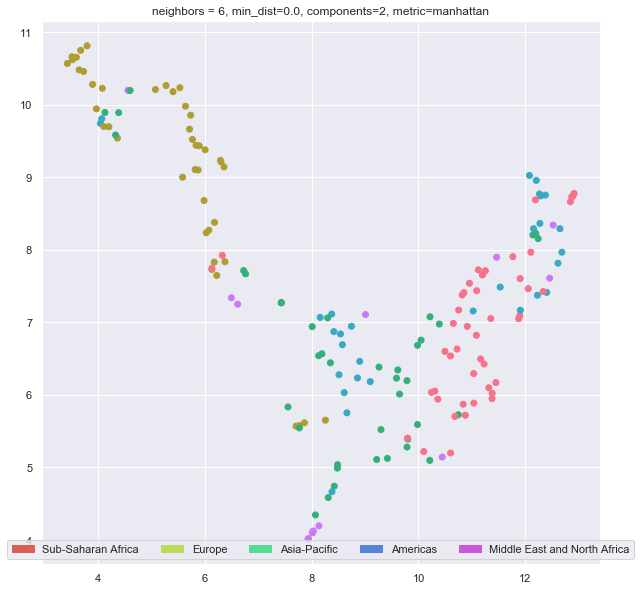

In [42]:
    projection = draw_umap(scaled_data_values, ["region"], n_neighbors=6, 
                       min_dist=0.0, n_components=2, metric='manhattan')

### Определяем принадлежность каждого элемента выборки определенному классу:

In [43]:
keys, d = make_dict(data_set['region'])
marks = [x for x in data_set['region'].map(d)]

### Делим выборку на обучающую и тестовую в соотношении 80/20:

In [44]:
x_train, x_test, y_train, y_test = train_test_split(raw_data, marks, test_size=0.2)

### Обучаем классификатор на тренировном наборе и запускаем на тестовом с последующим выводом процета правильно распознанных значений:

In [45]:
knn = KNeighborsClassifier(n_neighbors=6, weights='distance', metric='manhattan')#, algorithm='brute')
knn.fit(x_train, y_train)
result = knn.predict(x_test).tolist()

true_count = 0
for i, j in zip(result, y_test):
    if i == j: true_count += 1

true_count / len(y_test)

0.5142857142857142

### Функция вычисления строки в матрице ошибок:

In [46]:
def calc_matrix_row(class_ind, class_count, result, true_result):
    metrics = [0] * class_count

    for i, j in zip(result, true_result):
        if i == class_ind: metrics[j] += 1

    return metrics

### Вычисляем матрицу ошибок:

In [47]:
matrix = []

for i in knn.classes_:
    matrix.append(calc_matrix_row(i, len(knn.classes_), result, y_test))

pd.DataFrame(matrix, index=np.unique(data_set['region'].values), columns=np.unique(data_set['region'].values))

,Americas,Asia-Pacific,Europe,Middle East and North Africa,Sub-Saharan Africa
Americas,6,2,4,1,0
Asia-Pacific,0,5,2,2,2
Europe,1,0,3,1,0
Middle East and North Africa,0,1,0,4,1
Sub-Saharan Africa,0,0,0,0,0


### Метрика accuracy (показывает долю правильных ответов):

In [48]:
def accuracy(matrix):
    return sum(matrix[i][i] for i in range(len(matrix))) / np.sum(matrix)

accuracy(matrix)

0.5142857142857142

### Метрика precision (показывает точность предсказания):

In [49]:
def precision(matrix, i):
    return matrix[i][i] / np.sum(matrix, axis=0)[i]

def avg_precision(matrix):
    return np.average(list(map(lambda i: precision(matrix, i), range(len(matrix)))))

list(map(lambda i: precision(matrix, i), range(len(matrix))))

[0.8571428571428571, 0.625, 0.3333333333333333, 0.5, 0.0]

### Метрика recall (показывает полноту ответов):

In [50]:
def recall(matrix, i):
    return matrix[i][i] / np.sum(matrix, axis=1)[i]

def avg_recall(matrix):
    return np.average(list(map(lambda i: recall(matrix, i), range(len(matrix)))))

list(map(lambda i: recall(matrix, i), range(len(matrix))))

C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


[0.46153846153846156, 0.45454545454545453, 0.6, 0.6666666666666666, nan]

### Метрика F:

In [51]:
def f_metric(matrix):
    precisions = list(map(lambda i: precision(matrix, i), range(len(matrix))))
    recalls = list(map(lambda i: recall(matrix, i), range(len(matrix))))

    avg_precision = np.average(precisions)
    avg_recall = np.average(recalls)

    return 2.0 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

f_metric(matrix)

C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


nan

C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarnin

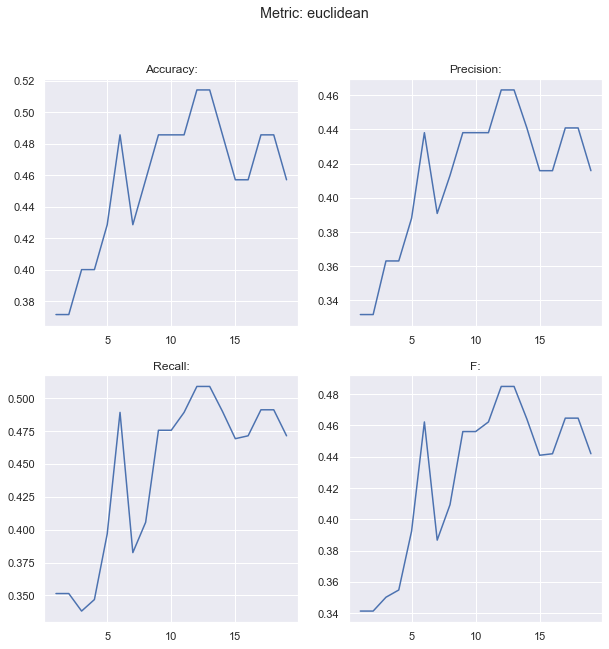

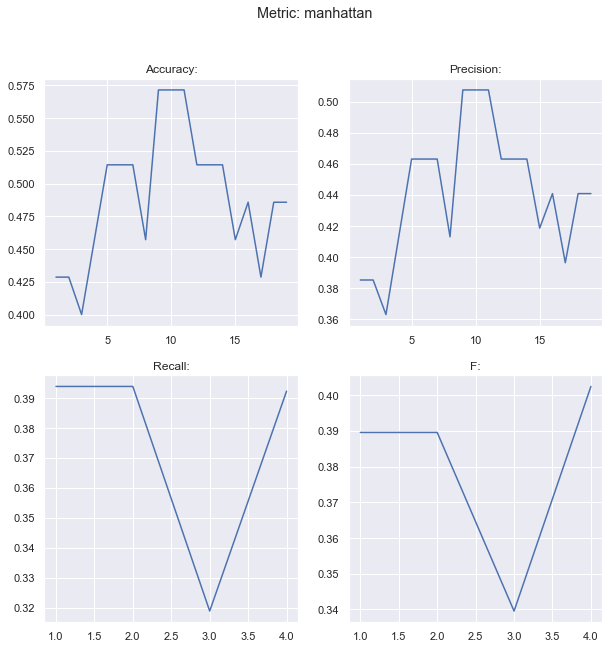

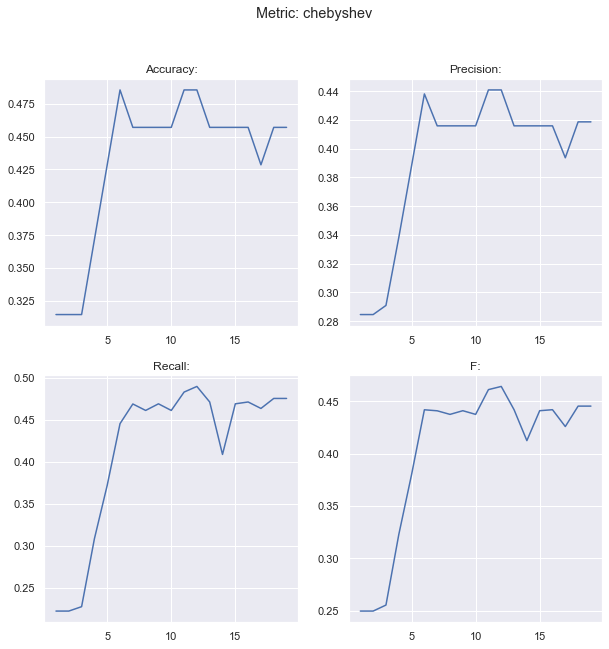

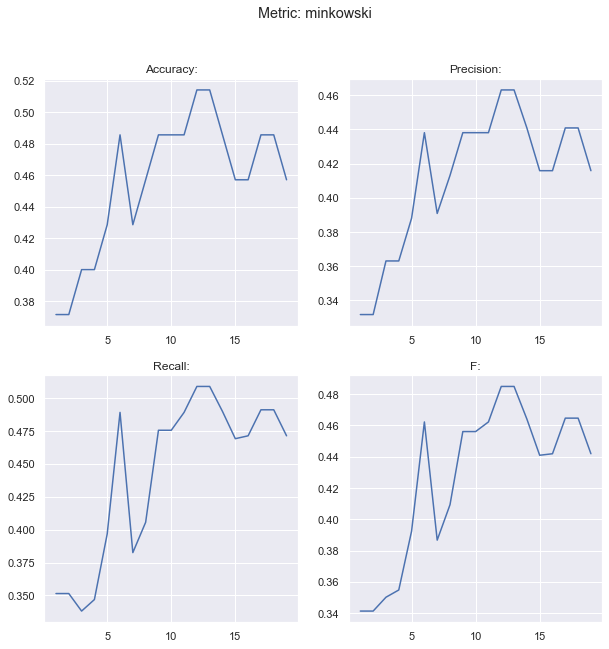

In [58]:
def calc_metrics_for_kneighbors(m):
    acc = []
    prec=[]
    rec = []
    fs = []
    k_range = range(1, 20)

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric=m)#, algorithm='brute')
        for i in range(10): knn.fit(x_train, y_train)
        result = knn.predict(x_test).tolist()

        matrix = []
        for i in knn.classes_:
            matrix.append(calc_matrix_row(i, len(knn.classes_), result, y_test))
    
        acc.append(accuracy(matrix))
        prec.append(avg_precision(matrix))
        rec.append(avg_recall(matrix))
        fs.append(f_metric(matrix))

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ax[0][0].plot(k_range, acc)
    ax[0][1].plot(k_range, prec)
    ax[1][0].plot(k_range, rec)
    ax[1][1].plot(k_range, fs)

    ax[0][0].set_title("Accuracy:")
    ax[0][1].set_title("Precision:")
    ax[1][0].set_title("Recall:")
    ax[1][1].set_title("F:")

    fig.suptitle("Metric: " + m)

metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

for m in metrics:
    calc_metrics_for_kneighbors(m)

### Дерево принятия решений:

In [59]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
tree.fit(x_train, y_train)
tree.predict(x_test)

array([1, 2, 0, 3, 3, 3, 0, 0, 2, 1, 3, 3, 3, 1, 3, 3, 0, 0, 3, 2, 2, 0,
       3, 3, 2, 1, 1, 3, 2, 3, 2, 3, 0, 1, 1])

C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\Qwerheh\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarnin

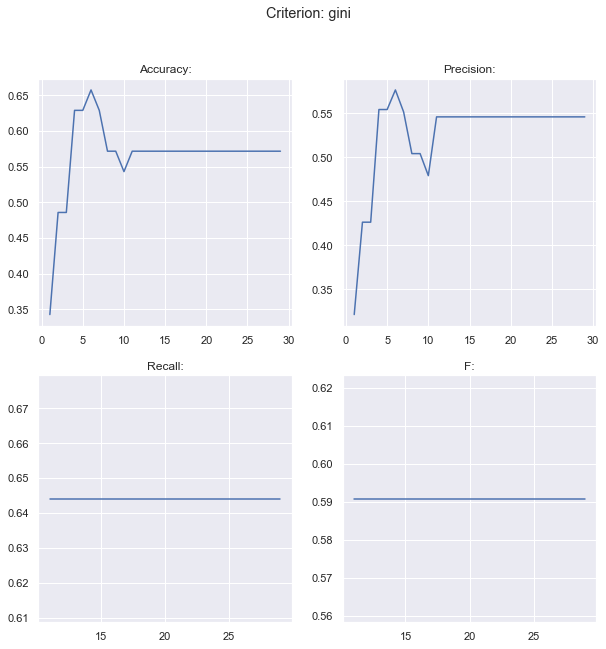

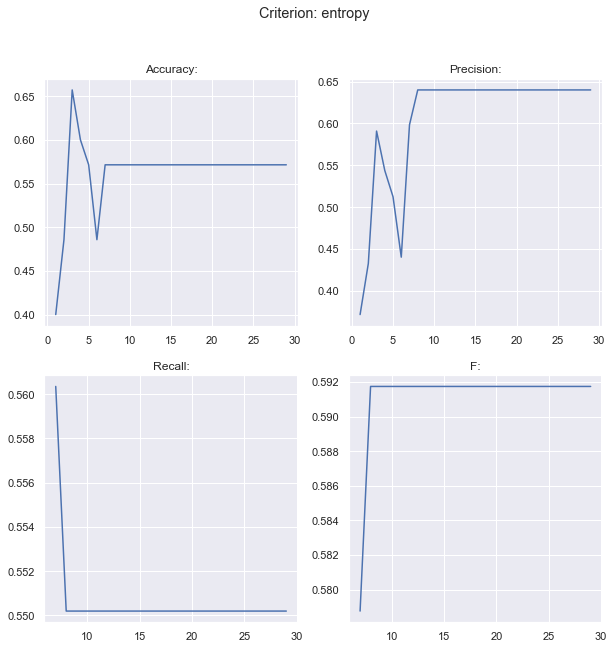

In [60]:
def calc_metrics_for_tree(crit):
    acc = []
    prec=[]
    rec = []
    fs = []
    d_range = range(1, 30)

    for d in d_range:
        knn = DecisionTreeClassifier(criterion=crit, max_depth=d, random_state=42)#, algorithm='brute')
        knn.fit(x_train, y_train)
        result = knn.predict(x_test).tolist()

        matrix = []
        for i in knn.classes_:
            matrix.append(calc_matrix_row(i, len(knn.classes_), result, y_test))
    
        acc.append(accuracy(matrix))
        prec.append(avg_precision(matrix))
        rec.append(avg_recall(matrix))
        fs.append(f_metric(matrix))

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ax[0][0].plot(d_range, acc)
    ax[0][1].plot(d_range, prec)
    ax[1][0].plot(d_range, rec)
    ax[1][1].plot(d_range, fs)

    ax[0][0].set_title("Accuracy:")
    ax[0][1].set_title("Precision:")
    ax[1][0].set_title("Recall:")
    ax[1][1].set_title("F:")

    fig.suptitle("Сriterion: " + crit)

calc_metrics_for_tree("gini")
calc_metrics_for_tree("entropy")